In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import python_speech_features as psf
import math
import h5py

### Read audiofiles

In [2]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
path = '/'.join(temp)
path += '/data/16kHz_16bit/'

In [3]:
def read_files():
    for root, dirnames, filenames in os.walk(path):
        arr = np.array([])
        for filename in filenames:
            if filename.endswith(('.wav')):
                fs, data = wavfile.read((os.path.join(root, filename)))
                try:
                    arr = np.concatenate((arr, data), axis=0)
                except:
                    arr = data
        try:
            if arr.shape[0] > 0:
                yield {'sample_rate': fs, 'signal': arr}
        except:
            continue
            
df = pd.DataFrame(read_files())
print('{num} .wav files are read'.format(num=df.shape[0]))

28 .wav files are read


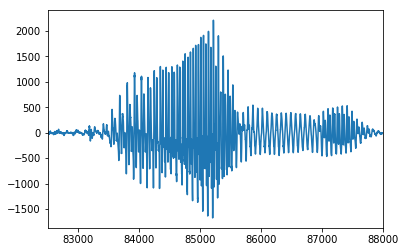

In [4]:
plt.plot(df.iloc[0]['signal'])
plt.xlim((82500, 88000))
plt.show()

In [5]:
mfcc = psf.mfcc(df.iloc[2]['signal'], samplerate=df.iloc[2]['sample_rate'], nfft=1024, nfilt=26, numcep=13, 
               winlen=0.025, winstep=0.01)

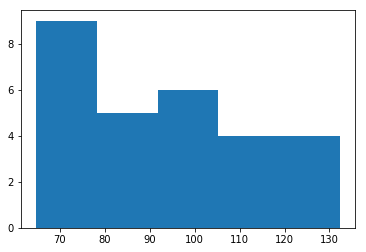

In [6]:
# length of files
l = []
for i in range(df.shape[0]):
    l.append(df.iloc[i]['signal'].shape[0]/df.iloc[i]['sample_rate'])
plt.hist(l, bins=5)
plt.show()

In [7]:
df.head()

,sample_rate,signal
0,16000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
1,16000,"[7.0, -11.0, 17.0, -209.0, -229.0, -253.0, -26..."
2,16000,"[-50.0, -100.0, -84.0, -62.0, -4.0, 99.0, 134...."
3,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0,..."
4,16000,"[40.0, 49.0, 36.0, 41.0, -3.0, 16.0, 72.0, 33...."


### Remove silence regions

In [8]:
# VAD - Voice Ativity Detection
from vad import VAD
regions = VAD(df.signal.iloc[0], int(df.sample_rate.iloc[0]), nFFT=512, win_length=0.02, hop_length=0.01, threshold=0.65)

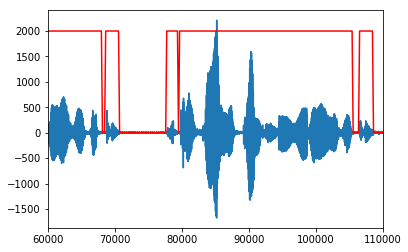

In [9]:
plt.plot(df.signal.iloc[0])
plt.plot([160 * i for i in range(regions.shape[0])], 2000*regions, color='red')
plt.xlim((60000, 110000))
plt.show()

In [10]:
# remove non-speech regions
def remove_silence(signal):
    regions = VAD(signal, int(df.sample_rate.iloc[0]), nFFT=512, win_length=0.02, hop_length=0.01, threshold=0.65)
        
    without_silence = np.array([ signal[160*i : 160*(i + 1)] for i in range(regions.shape[0]) if regions[i] > 0])
    without_silence = without_silence.flatten()
    return without_silence
    
    
df['speech'] = df.signal.apply(lambda signal: remove_silence(signal))

In [11]:
df.head()

,sample_rate,signal,speech
0,16000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0..."
1,16000,"[7.0, -11.0, 17.0, -209.0, -229.0, -253.0, -26...","[-85.0, -73.0, -79.0, -101.0, -72.0, -57.0, -6..."
2,16000,"[-50.0, -100.0, -84.0, -62.0, -4.0, 99.0, 134....","[-163.0, -114.0, -76.0, -63.0, -44.0, -57.0, -..."
3,16000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0,...","[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,..."
4,16000,"[40.0, 49.0, 36.0, 41.0, -3.0, 16.0, 72.0, 33....","[-8.0, -2.0, 3.0, 4.0, 0.0, -9.0, -20.0, -13.0..."


In [12]:
# length of records in sec
l = df.speech.apply(lambda x: x.shape[0]/16000)

### Mix files to create labeled data

In [13]:
def create_by_sum(df, n_voices, n_instances, n_seconds=10):
    
    def sum_signals(add_array):
        # need to equalize the length
        nonlocal mixture
        try:
            if mixture.shape[0] > add_array.shape[0]:
                c = mixture
                c[:add_array.shape[0]] += add_array
                mixture = c
            else:
                c = add_array
                c[:mixture.shape[0]] += mixture
                mixture = c
            pass
        except:
            mixture = add_array
            pass
    
    for i in range (n_instances):
        sampled = df.sample(n=n_voices)
        mixture = np.array([])
        sampled.speech.apply(lambda arr: sum_signals(arr))
        
        # yield random part of recording n_seconds long
        length_of_reg = int(n_seconds * sampled.sample_rate.iloc[0])
        rand_reg = np.random.uniform()
        reg_begin = int(rand_reg * (mixture.shape[0] - length_of_reg))
        mixture = mixture[reg_begin : reg_begin + length_of_reg]
        
        if n_voices <=4:
            yield {'voices': n_voices , 'signal': mixture}
        else:
            yield {'voices': 4 , 'signal': mixture}


In [14]:
train_samples = pd.concat([pd.DataFrame(create_by_sum(df, 1, 15)), pd.DataFrame(create_by_sum(df, 2, 15)), pd.DataFrame(create_by_sum(df, 3, 15)),
                           pd.DataFrame(create_by_sum(df, 4, 8)), pd.DataFrame(create_by_sum(df, 5, 5))])
train_samples = train_samples.reset_index(drop=True)


In [15]:
train_samples.signal.iloc[4].shape, train_samples.signal.iloc[6].shape,

((160000,), (160000,))

In [16]:
train_samples.tail()

,signal,voices
53,"[18066.0, 31982.0, 54057.0, 69996.0, 72684.0, ...",4
54,"[48040.0, 58124.0, 78555.0, 32777.0, 54822.0, ...",4
55,"[-94305.0, -50574.0, -88402.0, -126120.0, -105...",4
56,"[-50016.0, -60377.0, -67493.0, -55012.0, -3919...",4
57,"[6193.0, 1476.0, -153.0, -2866.0, -5770.0, -49...",4


### Extract MFCC features

In [17]:
# for MFCC features scanning window is 0.02 sec and the step is 0.01
sample_rate = df.sample_rate.iloc[0]
def make_features(signal):
    mfcc = psf.mfcc(signal, samplerate=sample_rate, nfft=1024, nfilt=26, numcep=13, winlen=0.02)
    return mfcc
    
train_samples['mfcc'] = train_samples.signal.apply(lambda signal: make_features(signal))

In [18]:
train_samples.iloc[4].mfcc.shape

(999, 13)

### Merge by N frames together

In [19]:
def merge_n_frames(array_2d, n_merge):
    array_2d = np.reshape(array_2d, (array_2d.shape[0], 1, array_2d.shape[1]))
    x = np.array([])
    for i in range(array_2d.shape[0]//n_merge):
        try:
            x = np.concatenate((x, np.stack(array_2d[i*n_merge: i*n_merge + n_merge], axis=1)), axis=0)
        except:
            x = np.stack(array_2d[i*n_merge: i*n_merge + n_merge], axis=1)
    return x

In [20]:
n_merge = 16  # stack N frames together

train_samples['merged'] = train_samples.mfcc.apply(lambda mfcc_arr: merge_n_frames(mfcc_arr, n_merge))

In [21]:
train_samples.head()

,signal,voices,mfcc,merged
0,"[485.0, 454.0, 419.0, 361.0, 349.0, 312.0, 262...",1,"[[13.61958492109509, 6.489148026432648, 11.332...","[[[13.61958492109509, 6.489148026432648, 11.33..."
1,"[-13663.0, -18369.0, -19927.0, -19402.0, -1532...",1,"[[21.014241876351115, -1.925671981386886, -3.9...","[[[21.014241876351115, -1.925671981386886, -3...."
2,"[2131.0, 1891.0, 1630.0, 1540.0, 1786.0, 2214....",1,"[[19.21745400702167, 10.190464121870278, 0.695...","[[[19.21745400702167, 10.190464121870278, 0.69..."
3,"[5452.0, 4838.0, 3832.0, 3293.0, 1127.0, -42.0...",1,"[[20.403817307829865, -9.787634741165588, -15....","[[[20.403817307829865, -9.787634741165588, -15..."
4,"[40.0, 35.0, -18.0, -62.0, -102.0, -135.0, -13...",1,"[[13.384663035099901, 2.454952924514012, -26.5...","[[[13.384663035099901, 2.454952924514012, -26...."


### Create a target column

In [22]:
def extend_target(record):
    return [record.voices for i in range(record.merged.shape[0])]

train_samples['target'] = train_samples.apply(lambda row: extend_target(row), axis=1)

### Merge all the rows in one array

In [23]:
X_train = np.concatenate(train_samples.merged, axis=0)
Y_train = np.concatenate(train_samples.target, axis=0)

# and make dummy target
Y_train = pd.get_dummies(Y_train)

X_train.shape, Y_train.shape

((3596, 16, 13), (3596, 4))

### Save train file

In [24]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
path = '/'.join(temp)
with h5py.File(path + '/data/train_{frames}frames.h5'.format(frames=n_merge), 'w') as h5file:
    h5file.create_dataset('train', data=X_train)
    h5file.create_dataset('target', data=Y_train)
    h5file.close()